In [1]:
# !git clone https://github.com/kornia/kornia.git
!pip -q install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 9.6 MB/s eta 0:00:00


In [37]:
from typing import Any, Dict, Optional, Union

import torch
import torchvision.transforms as transforms

from kornia.core import Module, Tensor
from kornia.geometry import resize
from kornia.utils.helpers import map_location_to_cpu

from kornia.feature.loftr.loftr import LoFTR, default_cfg

default_cfg = {
    'backbone_type': 'ResNetFPN',
    'resolution': (8, 2),
    'fine_window_size': 5,
    'fine_concat_coarse_feat': True,
    'resnetfpn': {'initial_dim': 128, 'block_dims': [128, 196, 256]},
    'coarse': {
        'd_model': 256,
        'd_ffn': 256,
        'nhead': 8,
        'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'],
        'attention': 'linear',
        'temp_bug_fix': False,
    },
    'match_coarse': {
        'thr': 0.2,
        'border_rm': 2,
        'match_type': 'dual_softmax',
        'dsmax_temperature': 0.1,
        'skh_iters': 3,
        'skh_init_bin_score': 1.0,
        'skh_prefilter': True,
        'train_coarse_percent': 0.4,
        'train_pad_num_gt_min': 200,
    },
    'fine': {'d_model': 128, 'd_ffn': 128, 'nhead': 8, 'layer_names': ['self', 'cross'], 'attention': 'linear'},
}

class LoFTRInference:
    def __init__(self, pretrained: Optional[str] = 'outdoor', config: Dict[str, Any] = default_cfg):
        self.loftr = LoFTR(pretrained, config)
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert image to Tensor
            # Add any other preprocessing transforms you may need
        ])

    def preprocess_image(self, image):
        # Preprocess the input image
        # You may need to resize, normalize, or apply other transformations
        preprocessed_image = self.transform(image)
        return preprocessed_image

    def postprocess_result(self, result):
        # Postprocess the model output if needed
        # Extract the required information from the result dictionary
        # You can also visualize the matching or perform any other custom processing
        return result

    def infer(self, image0, image1):
        # Preprocess the input images
        preprocessed_image0 = self.preprocess_image(image0)
        preprocessed_image1 = self.preprocess_image(image1)

        # Prepare the input data dictionary
        input_data = {"image0": preprocessed_image0.unsqueeze(0), "image1": preprocessed_image1.unsqueeze(0)}

        # Perform inference using the LoFTR model
        result = self.loftr(input_data)

        # Postprocess the result
        output = self.postprocess_result(result)

        return output

import cv2, time
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# import matplotlib.pyplot as plt

# Create an instance of the LoFTRInference class
loftr = LoFTRInference()

def matching_operation(image1, image2):

    # Resize the images to have the same dimensions
    image1 = cv2.resize(image1, (300, 200))  # Adjust the dimensions as needed
    image2 = cv2.resize(image2, (300, 200))  # Adjust the dimensions as needed

    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Convert the images to tensors
    image1_tensor = torch.from_numpy(image1_gray).unsqueeze(0).float() / 255.0
    image2_tensor = torch.from_numpy(image2_gray).unsqueeze(0).float() / 255.0

    # Remove the extra dimensions from tensors
    image1_tensor = image1_tensor.squeeze(0)
    image2_tensor = image2_tensor.squeeze(0)

    # Convert tensors to PIL Images
    image1_pil = transforms.ToPILImage()(image1_tensor)
    image2_pil = transforms.ToPILImage()(image2_tensor)

    t1 = time.time()
    # Perform inference
    output = loftr.infer(image1_pil, image2_pil)
    print("time taken for actual inference:", time.time() - t1)

    # Access the output values
    keypoints1 = output['keypoints0']  # Matching keypoints from image1
    keypoints2 = output['keypoints1']  # Matching keypoints from image2
    confidence = output['confidence']  # Confidence scores

    # Draw keypoints on the images
    for kp in keypoints1:
        x, y = kp[0], kp[1]
        cv2.circle(image1, (int(x), int(y)), 3, (0, 255, 0), -1)

    for kp in keypoints2:
        x, y = kp[0], kp[1]
        cv2.circle(image2, (int(x), int(y)), 3, (0, 255, 0), -1)

    # Combine the images side by side
    combined_image = np.concatenate((image1, image2), axis=1)

    # Convert the combined image to RGB format
    combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

    return combined_image_rgb

time taken for actual inference: 2.6081361770629883
total time taken: 2.6222047805786133


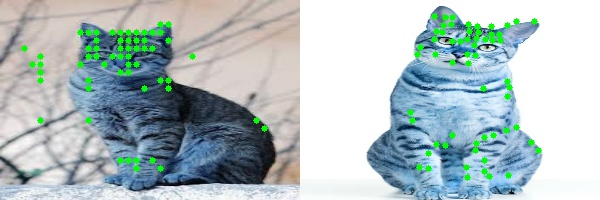

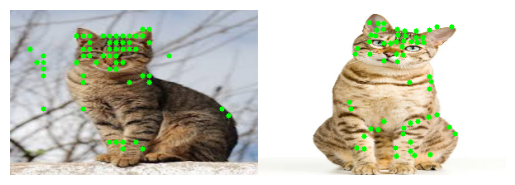

In [39]:
image1_path = os.path.join(os.getcwd(),'image3.jpg')
image2_path = os.path.join(os.getcwd(),'image4.jpg')
output_image_path = os.path.join(os.getcwd(),'output_image.jpg')

t1 = time.time()
# Load the input images
image1 = cv2.imread(image1_path, cv2.IMREAD_COLOR)
image2 = cv2.imread(image2_path, cv2.IMREAD_COLOR)

output_image = matching_operation(image1, image2)
print("total time taken:", time.time()-t1)
cv2.imwrite(output_image_path, output_image)

# cv2.imshow("Output Image", output_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread(output_image_path))

import matplotlib.pyplot as plt
plt.imshow(output_image)
plt.axis('off')
plt.show()

In [5]:
!pip -q install fastapi uvicorn starlette nest_asyncio pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00


In [6]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5029)"))

https://6yrqva1ck7-496ff2e9c6d22116-5029-colab.googleusercontent.com/


In [9]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
from pydantic import BaseModel
import cv2
import numpy as np
# from PIL import Image
import base64, os, io, json
import time

# from matching import matching_operation

app = FastAPI(
    title="image_matching",
    description="return base64 result image after matching",
    version="0.1.0")
origins = ["*"]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],)

class ImageRequest(BaseModel):
    image1: str
    image2: str

class ImageResponse(BaseModel):
    output_image: str

def check_and_modify_b64(base64_image):
  if ";base64," in base64_image:
      base64_image = base64_image.split(";base64,")[1].encode("utf8")
  else:
      base64_image = base64_image.encode("utf8")
  return base64_image

def process_images(image1_base64: str, image2_base64: str) -> str:
    start = time.time()
    image1_base64 = check_and_modify_b64(image1_base64)
    image2_base64 = check_and_modify_b64(image2_base64)

    # try:
    #     imgdata = base64.b64decode(image1_base64)
    #     image = Image.open(io.BytesIO(imgdata))
    #     image.save('image1.png')
    #     imgdata = base64.b64decode(image2_base64)
    #     image = Image.open(io.BytesIO(imgdata))
    #     image.save('image2.png')
    # except Exception as e:
    #         print("Exception in image save", e)

    # Convert Base64 strings to NumPy arrays
    image1_data = base64.b64decode(image1_base64)
    image2_data = base64.b64decode(image2_base64)
    nparr1 = np.frombuffer(image1_data, np.uint8)
    nparr2 = np.frombuffer(image2_data, np.uint8)

    # Decode the images using OpenCV
    image1 = cv2.imdecode(nparr1, cv2.IMREAD_COLOR)
    image2 = cv2.imdecode(nparr2, cv2.IMREAD_COLOR)

    # Perform your desired image processing here
    # For example, concatenate the images side by side
    combined_image = matching_operation(image1, image2)

    # Encode the output image to Base64
    _, output_image_data = cv2.imencode('.jpg', combined_image)
    output_image_base64 = base64.b64encode(output_image_data).decode('utf-8')
    end = time.time()
    print("Total time taken =", end-start)
    return output_image_base64

@app.post("/process_images")
def process_images_endpoint(image_request: ImageRequest) -> ImageResponse:
    try:
        output_image_base64 = process_images(image_request.image1, image_request.image2)
    except Exception as e:
        print('Exception', e)
    return ImageResponse(output_image=output_image_base64)

# PORT = int(os.getenv("PORT")) if os.getenv("PORT") else 8000
# uvicorn.run(app, host="0.0.0.0", port=PORT)

In [10]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)


INFO:     Started server process [721]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://7b40-34-71-229-101.ngrok.io


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [721]


In [ ]:
# import requests
# import base64

# # Encode image data to Base64
# def image_to_base64(image_path):
#     with open(image_path, "rb") as image_file:
#         encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
#     return encoded_string

# # Base64 encoded images
# image1_base64 = image_to_base64('image3.jpg')
# image2_base64 = image_to_base64('image4.jpg')

# # API endpoint URL
# url = 'http://localhost:8000/process_images'
# url = 'https://7b40-34-71-229-101.ngrok.io/process_images'

# # Request payload
# payload = {
#     'image1': image1_base64,
#     'image2': image2_base64
# }

# # Send POST request
# response = requests.post(url, json=payload)

# # Check response status code
# if response.status_code == 200:
#     # Get the output image in Base64 format
#     output_image_base64 = response.json()['output_image']

#     # Decode the output image from Base64
#     output_image_data = base64.b64decode(output_image_base64)

#     # Save the output image to a file
#     with open('output_image1.jpg', 'wb') as file:
#         file.write(output_image_data)

#     print("Output image saved successfully.")
# else:
#     print("Error:", response.status_code, response.text)
